In [2]:
%matplotlib inline

In [3]:
# this script should turn out to be a working example of an Agent Based Model

# TODO:
#   - NN functionality / regular rules for predator/prey
#   - grass growing rate, etc.



# general stuff
import numpy as np
import matplotlib.pyplot as plt
import uuid
import random as rd
import copy  # needed for deepcopies
import datetime as dt

class Agent:
    """
    This class provides the necessary methods and attributes every agent should
    carry.
    Methods:
        - Move(args): moves the agent around in his neighbourhood
        - FeedOn(args): agent feeds on a given resource - if the resource is a
            prey, it can run away with a given probability. Increases _FoodReserve
            attribute.
        - Die(args): if the _FoodReserve is 0 or an Agent gets eaten it dies and
            is removed.

    Attributes:
        - _FoodReserve: tba
        - _GenCounter: (generation counter) if agents mate and create and offspring,
        this counter increases by 1. Merely a fun paramater as of this writing.
        (if used anyway)
        - _GridPosX/Y: X/Y position on the grid
    """

    # order of arguments in __init__ determines input order of arguments
    def __init__(self, agentsdict, FoodReserve, GridPos, GenCounter=0, MaxFoodReserve=None, pBreed=0.2):
        self._FoodReserve = FoodReserve
        self._MaxFoodReserve = MaxFoodReserve
        self._GenCounter = GenCounter
        self._GridPosX, self._GridPosY = GridPos
        self._ID = str(uuid.uuid4())
        agentsdict[self._ID] = self  # add the agent to the dictionary of agents with the ID as key
        self._kin = None
        self._pBreed = pBreed  # chance to create offspring 
        
    def Die(self):
        """
        If an agent dies, it is removed from the list of agents
        """
        del Agents[self._ID]

    def get_fr(self):
        """
        Getter-function for food reserve value
        """
        return self._FoodReserve

    def get_cgp(self):
        """
        Getter-function for current grid position.
        """
        return [self._GridPosX, self._GridPosY]

    def get_ID(self):
        """
        Getter-function for the agents ID.
        """
        return self._ID

    def get_gen(self):
        """
        Getter-function for the generation counter.
        """
        return self._GenCounter 
    
    def get_kin(self):
        """
        Getter-function for the kin type.
        """
        return self._kin
    
    def get_maxfr(self):
        """
        Getter-function for the maximum food reserve.
        """
        return self._MaxFoodReserve
    
    def get_pBreed(self):
        """
        Getter-function for the chance of creating offspring.
        """
        return self._pBreed
        
    def get_Nbh(self, gridObject):
        """
        This method returns a list of the moore neighbourhood of the agent. The
        numbering is the following:
            6 7 8
            3 4 5
            0 1 2
        So clearly the Agent is placed in cell nr. 4.
        """
        nbh = []
        delta = [-1, 0, 1]
        x = self._GridPosX  # current X position
        y = self._GridPosY  # current Y position
        wid = gridObject.get_width()  # grid width
        hei = gridObject.get_height()  # grid height
        for dy in delta:
            for dx in delta:
                nbh.append([(x + dx + wid)%wid, (y + dy + hei)%hei])
        return nbh
    
    def Move(self, gridObject, agentsdict, direction=-1):
        """
        This method moves the Agent to one of the neighbouring cells. If default value for direction remains 
        unchanged, the move is random. A prey can only move to empty cells. A predator can move to a cell already
        occupied by a prey to try and eat it with probability 1-pFlee. 
        """
        nbh = self.get_Nbh(gridObject)  # find neighbouring cells
        currentPos = gridObject.get_currentPositions(agentsdict)  # get current positions of all agents
        nbhAgents = [c for c in nbh if c in currentPos[1]]  # find agents in neighbourhood of said agent
        possibleMove = nbh[:]  # copy of neighbourhood for better understanding
        
        #if(self.get_kin() is not None):
        for n in nbhAgents:
            possibleMove.remove(n)  # remove all occupied neighbouring cells
            
        newPos = rd.choice(possibleMove)  # choose new position randomly
        self._GridPosX, self._GridPosY = newPos

    def Eat(self, gridObject, agentsdict):
        """
        This method lets an agent eat; whether its grass or prey. 
        """
        MaxFoodReserve = self.get_maxfr()
        #self._FoodReserve -= 1
        if(self._FoodReserve-1 <= 0):
            self._kin = None
        else:
            self._FoodReserve -= 1
        
        if(self._kin is "Prey" and self._FoodReserve < MaxFoodReserve - 1):
            self._FoodReserve += 2
            if(self._FoodReserve > MaxFoodReserve):
                self._FoodReserve = MaxFoodReserve
        
        elif(self._kin is "Pred"):
            nbh = self.get_Nbh(gridObject)
            currentPos = gridObject.get_currentPositions(agentsdict)
            nbhAgents = [c for c in nbh if c in currentPos[1]]
            if(len(nbhAgents) > 1):  # if neighbours contain more than the central agent 
                for n in nbhAgents:
                    idx = currentPos[1].index(n)
                    if(currentPos[2][idx] is "Pred" or currentPos[2][idx] is None):
                        nbhAgents.remove(n)  # remove all predator agents in the neighbourhood
                
                if(len(nbhAgents)>0):
                    foodpos = rd.choice(nbhAgents)
                    # TODO: possibility to flee 
                    food_idx = currentPos[1].index(foodpos)  # index of prey to be eaten in list of current agent pos
                    agentsdict[currentPos[0][food_idx]]._kin = None  # set kin type to None for later cleanup
                    self._GridPosX, self._GridPosY = foodpos  # move pred to preys position
                    self._FoodReserve += 2  # actual eating 
                    if(self._FoodReserve > MaxFoodReserve):
                        self._FoodReserve = MaxFoodReserve
                    
                else:
                    self.Move(gridObject, agentsdict)
            else:
                self.Move(gridObject, agentsdict)
    
    def createOffspring(self, gridObject, agentsdict, newbornDict):
        if(self._FoodReserve > self._MaxFoodReserve/2):
            self._FoodReserve = self._FoodReserve - 4  # TODO: parameterize this !!!!
            nbh = self.get_Nbh(gridObject)  # get neighbourhood positions
            currentPos = gridObject.get_currentPositions(agentsdict)
            nbhAgents = [c for c in nbh if c in currentPos[1]]  # find agents in neighbourhood of said agent
            possiblePlace = nbh[:]  # copy of neighbourhood for better understanding
        
            for n in nbhAgents:
                possiblePlace.remove(n)  # remove all occupied neighbouring cells
            
            if(len(possiblePlace)):
                newPos = rd.choice(possiblePlace)  # choose new position randomly
                newgen = self._GenCounter +1
            
                # offspring -> newborn dictionary
                if(self._kin is "Pred"):                
                    Predator(newbornDict, FoodReserve=4, GridPos=newPos, MaxFoodReserve=8, GenCounter=newgen) 
            
                elif(self._kin is "Prey"):
                    Prey(newbornDict, FoodReserve=4, GridPos=newPos, MaxFoodReserve=8, GenCounter=newgen)
                

            # seems to work... 
            
class Predator(Agent):
    """
    This class is derived from the Agent class.
    """

    def __init__(self, agentsdict, FoodReserve, GridPos, GenCounter=0, MaxFoodReserve=None, pBreed=0.3):
        super().__init__(agentsdict, FoodReserve, GridPos, GenCounter, MaxFoodReserve, pBreed)
        self._kin = "Pred"

class Prey(Agent):
    """
    This class is derived from the Agent class.
    """
    
    def __init__(self, agentsdict, FoodReserve, GridPos, GenCounter=0, MaxFoodReserve=None, pBreed=0.2, pFlee=0.2):
        super().__init__(agentsdict, FoodReserve, GridPos, GenCounter, MaxFoodReserve, pBreed)
        self._kin = "Prey"
        self._pFlee = pFlee  # chance to run away from predator 
        # TODO: implement fleeing 
    
class Grid:
    """
    TODO: docstring!
    """
    def __init__(self, width, height, cc=-1):
        self._width = width
        self._height = height
        self._grid = []
        
        if(cc is -1):  # cc = carrying capacity of the grid = number of possible agents
            # if default value of -1 remains unchanged, the maximum number of agents is used
            self._cc = self._width * self._height
        
        # initializing grid positions
        for y in range(self._height):
            for x in range(self._width):
                self._grid.append([x,y])
                # TODO: maybe each cell carries a list of coordinates, and a list
                # what it contains. e.g. [[x, y], [<Agent/Grass/Nothing>]]
    
    def get_width(self):
        """
        Getter-function for the grid width.  
        """
        return self._width

    def get_height(self):
        """
        Getter-function for the grid height.  
        """
        return self._height

    def get_grid(self):
        """
        Getter-function for the grid positions. 
        """
        return self._grid 
    
    def get_cc(self):
        """
        Getter-function for the carrying capacity for the grid
        """
        return self._cc
        
    def initialPositions(self, nAgents):  # maybe move this method to the initial part. 
        """
        This method returns a list of grid positions randomly selected for a given number of Agents. 
        """
        # TODO: Error handling if too many agents are given. 
        shuffledGrid = copy.deepcopy(self._grid)
        rd.shuffle(shuffledGrid)
        return shuffledGrid[:nAgents]
    
    def get_currentPositions(self, agentsdict):
        """
        This method returns a list of the currently occupied cell positions and the occupants type (e.g. Predator, 
        Prey). 
        """
        IDs = []
        cgps = []
        kins = []
        for ID, agent in agentsdict.items():
            IDs.append(ID)
            cgps.append(agent.get_cgp())
            kins.append(agent.get_kin())
        return [IDs, cgps, kins]

In [5]:
# TODO: cleanup of code here; create a base function for plotting, use colors and markers as optional arguments
def plotAgents(ax, positions, label, marker='.', color='k', s=100, zorder=None, preprocess=True):
    if(preprocess):
        positions = np.array(positions).T
    ax.scatter(*positions, marker=marker, color=color, s=s, label=label, zorder=zorder)

def plotNbh(ax, positions, label='Nbh', centerlabel='Nbh center', marker='s', centermarker='x', color='yellow', 
            s=200, centers=100, zorder=0, centerzorder=100):
    
    plotAgents(ax=ax, positions=positions, label=label, marker=marker, color=color, s=s, zorder=zorder)
    center = np.array(positions)[4]
    plotAgents(ax=ax, positions=center, label=centerlabel, marker=centermarker, color='k', s=centers, 
               zorder=centerzorder, preprocess=False)

def show_agents(grid, Agents, showgrid=False, showlegend=False, figsize=(9,9), savefig=False, title=''):
    preypos = []
    predpos = []
    kinless = []
    for a in Agents.values():
        kin = a.get_kin()
        cgp = a.get_cgp()
        if kin is "Prey":
            preypos.append(cgp)
        elif kin is "Pred":
            predpos.append(cgp)
        elif kin is None:
            kinless.append(cgp)
    
    #plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    if(showgrid):
        plotAgents(ax, grid.get_grid(), label='Grid', color='k')
    plotAgents(ax, preypos, label='Prey', color='g', zorder=10, s=10)
    plotAgents(ax, predpos, label='Predator', color='r', zorder=10, s=10)
    if(len(kinless)):
        plotAgents(ax, kinless, label='Kinless', color='k', zorder=1000, s=500)
    
    if(showlegend):
        ax.legend(bbox_to_anchor=(1.25, 1.0), fontsize=12)
    
    if(len(title)):
        ax.set_title(title)
    
    if(savefig):
        fig.savefig('plots/' + str(dt.datetime.now()) + '.png', dpi=200)
    return fig, ax
    
def show_nbh(grid, Agents, agent_ID, savefig=False):
    
    fig, ax = show_agents(grid, Agents)
    plotNbh(ax, Agents[agent_ID].get_Nbh(grid))
    ax.legend(bbox_to_anchor=(1.25, 1.0), fontsize=12)
    
    if(savefig):
        fig.savefig('plots/' + str(dt.datetime.now()) + '.png', dpi=200)
    # TODO: spacing of plot and legend; legend is cropped at the moment.

def mean_food(Agents):
    foodres = []
    for agent in Agents.values():
        foodres.append(agent.get_fr())
    return np.mean(foodres)

def Agents_cleanup(agentsdict):
    IDs = []
    for _ in agentsdict.keys():
        IDs.append(_)
    
    for ID in IDs:
        if(agentsdict[ID].get_kin() is None):
            agentsdict[ID].Die()

def lifecycle(agentsdict, newborndict, gridObject):
    # death cometh before new life may arise
    IDs = []
    for _ in agentsdict.keys():
        IDs.append(_)
    
    # remove all agents who died in the last iteration, i.e. have kintype None.
    for ID in IDs:
        if(agentsdict[ID].get_kin() is None):
            agentsdict[ID].Die()
            
    # new life shall arise from thy ashes:
    agentpos = gridObject.get_currentPositions(agentsdict)
    newagentpos = gridObject.get_currentPositions(newborndict)
    
    for newID, newagent in newborndict.items():
        if newagent.get_cgp() not in agentpos[1]:
            agentsdict[newID] = newagent
        
        else:
            pass
            #maybe I should to something about that. TODO? 
    
    # all newborn who have no place in this world shall now be brought to a better place. 
    newborndict.clear()
    
    
#show_nbh(grid, Agents, testID)
#show_agents(grid, Agents, showgrid=True)

#mean_food(Agents)

In [10]:
Agents = dict() # initialize empty agent dictionary
newborn = dict()

# fixed seed for reproducability
rd.seed(a=12345678)

# grid
w = 300
h = 300

"""
# agent division in preds and preys 
num_agents = 10000
preypredratio = 5
npred = num_agents//(preypredratio+1)
nprey = num_agents - npred
"""

# general 
food_res = 4

# inits
grid = Grid(w,h)


# new approach - initial densities:
rhoPrey = 0.2
rhoPred = 0.215
CarryingCapacity = grid.get_cc()
npred = int(CarryingCapacity * rhoPred)
nprey = int(CarryingCapacity * rhoPrey)
num_agents = npred + nprey

# positions:
ipos = grid.initialPositions(num_agents)

# preds
for _ in range(npred):
    Predator(Agents, food_res, ipos[_], MaxFoodReserve=8)

# preys 
for _ in range(npred, num_agents):
    Prey(Agents, food_res, ipos[_], MaxFoodReserve=8)

#IDs = []
#_IDs = Agents.keys()

#for _ in _IDs:
#    IDs.append(_)

#testID = IDs[100]

# actual simulation below here. 
fig, ax = show_agents(grid, Agents, savefig=True, title="Init" + ", Agents: " + str(len(Agents)))
plt.close(fig)
for _ in range(100):
    for ID, a in Agents.items():
        if(a.get_kin() is not None):
            roll = rd.random()
            if(roll < a.get_pBreed()):
                a.createOffspring(grid, Agents, newborn)
            else:
                a.Eat(grid, Agents)
    lifecycle(Agents, newborn, grid)  # cleanup all the dead Agents
    fig, ax = show_agents(grid, Agents, savefig=True, title="timestep " + str(_) + ", Agents: " + str(len(Agents)))
    plt.close(fig)

KeyboardInterrupt: 

In [6]:
for _ in range(500):
    for ID, a in Agents.items():
        if(a.get_kin() is not None):
            roll = rd.random()
            if(roll < a.get_pBreed()):
                a.createOffspring(grid, Agents, newborn)
            else:
                a.Eat(grid, Agents)
    lifecycle(Agents, newborn, grid)  # cleanup all the dead Agents
    fig, ax = show_agents(grid, Agents, savefig=True)
    plt.close(fig)

In [13]:
cnt = 0
for a in Agents.values():
    if a.get_kin() is not None:
        cnt += 1
print(cnt)

95190


In [ ]:
"""
TODO: breeding and adding new agents. 
Problems: again changing dictionary; idea: new kintype "newbornPrey", "newbornPred", who are added after one 
    iteration. 
Problem: what if the place is now occupied by another agent? idea: place every agent, whose cell would be occupied
    by just a single agent. if there are 2 or more agents to be placed, randomly select one.
"""

In [92]:
"""
More TODO: cleanup of figures, i.e. close every figure when it's finished. 
        add an indicator for progress of the simulation 
        add density plots for the whole timeseries

"""

"\nMore TODO: cleanup of figures, i.e. close every figure when it's finished. \n        add an indicator for progress of the simulation \n        add density plots for the whole timeseries\n\n"

In [ ]:
"""
TODO: in Eat method, make sure that predators don't eat the same prey, i.e. also remove the kintype 'None' from 
    the list of edibles
    more indicators, like number of agents, densities of preds & prey
    save the state of the last simulation step for later runs
"""

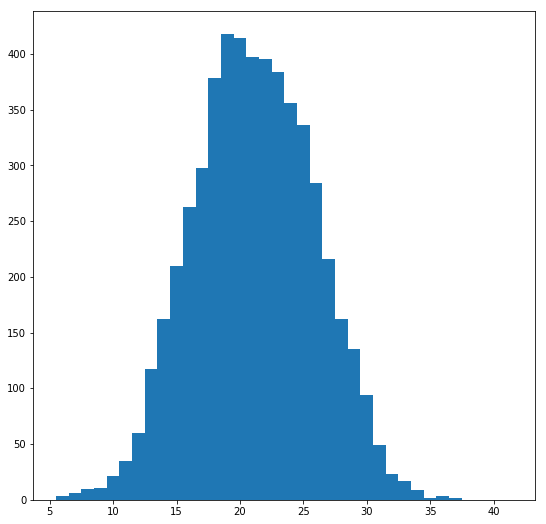

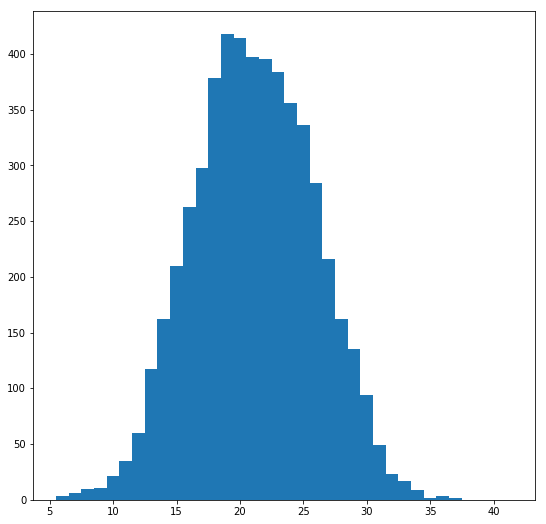

In [5]:
gen = []
for a in Agents.values():
    gen.append(a.get_gen())
    
genmin = min(gen)
genmax = max(gen)

edges = []
for _ in range(genmax):
    edges.append(genmin-0.5 + _)

plt.figure(figsize=(9,9))    
plt.hist(gen, bins=edges)
plt.show()

In [111]:
fig = plt.figure()
plt.close(fig)